In [ ]:
%matplotlib qt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.signal import butter, filtfilt, find_peaks, peak_widths, peak_prominences
from scipy.ndimage import gaussian_filter1d

# =========================================================
# 1. CONFIGURATION
# =========================================================
SESSION = "a2"
STIM = "pinch_tail"

# Tuning Defaults
INITIAL_THRESHOLD = 1.5  
USE_ADAPTIVE_THRESHOLD = False  
ADAPTIVE_PERCENTILE = 99  

MIN_PROMINENCE = 2.0      
MIN_PEAK_WIDTH_MS = 100   
MIN_DIST_SEC = 1         
FILTER_BAND = (5, 100)    
SMOOTHING_SIGMA_MS = 50   

# =========================================================
# 2. LOAD DATA
# =========================================================
csv_path = Path("data/sessions.csv")
if Path("data/sessions_local.csv").exists():
    csv_path = Path("data/sessions_local.csv")

sessions = pd.read_csv(csv_path)
row = sessions.loc[(sessions['session'].str.lower() == SESSION.lower()) & 
                   (sessions['stim'].str.lower() == STIM.lower())].iloc[0]

phy_dir = Path(row['phy_dir'])
lfp_dir = Path(row['lfp_dir'])
lfp_file = lfp_dir / 'continuous.dat'

# Map S1 Channels
chan_pos = np.load(phy_dir / 'channel_positions.npy')
depths = chan_pos[:, 1]
s1_upper = float(row['s1_upper_um'])
s1_lower = float(row['s1_lower_um'])
s1_mask = (depths >= s1_lower) & (depths <= s1_upper)
s1_indices = np.where(s1_mask)[0]

print(f"Target: {SESSION} | {STIM}")
print(f"Using {len(s1_indices)} channels in S1.")

# =========================================================
# 3. LOAD SPIKES (New Section)
# =========================================================
print("Loading spikes...")
spike_times = np.load(phy_dir / 'spike_times.npy').flatten()
spike_clusters = np.load(phy_dir / 'spike_clusters.npy').flatten()
cluster_info = pd.read_csv(phy_dir / 'cluster_info.tsv', sep='\t')

# Handle varying column names for quality
label_col = 'KSLabel' if 'KSLabel' in cluster_info.columns else 'group'

# Filter for S1 "Good" and "MUA" units
s1_units = cluster_info[
    (cluster_info['depth'] >= s1_lower) & 
    (cluster_info['depth'] <= s1_upper) &
    (cluster_info[label_col].isin(['good', 'mua']))
]

# Create a map for fast lookup
unit_depth_map = dict(zip(s1_units['cluster_id'], s1_units['depth']))
valid_ids = set(s1_units['cluster_id'])

# Filter spike arrays to only S1
mask_s1 = np.isin(spike_clusters, list(valid_ids))
s1_spike_times_sec = spike_times[mask_s1] / 30000.0
s1_spike_clusters = spike_clusters[mask_s1]

# Map clusters to depths for plotting
# (Using pandas map is often faster/cleaner for large arrays)
df_spikes = pd.DataFrame({'time': s1_spike_times_sec, 'cluster': s1_spike_clusters})
df_spikes['depth'] = df_spikes['cluster'].map(unit_depth_map)

print(f"Loaded {len(df_spikes)} spikes from {len(s1_units)} S1 units.")

# =========================================================
# 4. PROCESS S1 LFP
# =========================================================
fs_lfp = 2500.0
n_channels = 384
mm_lfp = np.memmap(lfp_file, dtype=np.int16, mode='r')
data = mm_lfp.reshape(-1, n_channels)
s1_data = data[:, s1_indices].astype(np.float32)

t = np.arange(s1_data.shape[0]) / fs_lfp

print("Filtering LFP...")
b, a = butter(2, FILTER_BAND, btype='bandpass', fs=fs_lfp)
filt_data = filtfilt(b, a, s1_data, axis=0)

# Energy Trace
print("Computing RMS energy...")
energy_trace = np.sqrt(np.mean(filt_data**2, axis=1))
smoothing_sigma = (SMOOTHING_SIGMA_MS / 1000.0) * fs_lfp
energy_trace_smooth = gaussian_filter1d(energy_trace, sigma=smoothing_sigma)
z_energy = (energy_trace_smooth - np.mean(energy_trace_smooth)) / np.std(energy_trace_smooth)

# =========================================================
# 5. AUTO-DETECT 
# =========================================================
def debounce_events(times, min_dist):
    if len(times) == 0: return []
    times = np.sort(times)
    kept = [times[0]]
    for x in times[1:]:
        if x - kept[-1] > min_dist:
            kept.append(x)
    return kept

if USE_ADAPTIVE_THRESHOLD:
    threshold = np.percentile(z_energy, ADAPTIVE_PERCENTILE)
    print(f"Using adaptive threshold: {threshold:.2f}")
else:
    threshold = INITIAL_THRESHOLD
    print(f"Using fixed threshold: {threshold}")

peaks, _ = find_peaks(z_energy, height=threshold, distance=int(MIN_DIST_SEC * fs_lfp))

current_stim_times = []
if len(peaks) > 0:
    _, _, left_ips, _ = peak_widths(z_energy, peaks, rel_height=0.95)
    onset_indices = np.floor(left_ips).astype(int)
    raw_times = list(t[onset_indices])
    current_stim_times = debounce_events(raw_times, MIN_DIST_SEC)
    print(f"Auto-detected {len(current_stim_times)} events.")

# =========================================================
# 6. INTERACTIVE EDITOR
# =========================================================
print("\n--- CONTROLS ---")
print("LEFT CLICK:  Add Event")
print("RIGHT CLICK: Remove Nearest Event")
print("PRESS 'Q':   Save & Quit")
print("----------------")

# Create 3 subplots now
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True, 
                                    gridspec_kw={'height_ratios': [2, 1.5, 1]})

# --- TOP PLOT: LFP Waterfall ---
n_plot = 50
subset_idx = np.linspace(0, filt_data.shape[1]-1, n_plot, dtype=int)
offset_uv = 500

for i, ch_idx in enumerate(subset_idx):
    trace = filt_data[::10, ch_idx] + (i * offset_uv)
    ax1.plot(t[::10], trace, color='black', lw=0.5, alpha=0.7)

ax1.set_ylabel("LFP (Stacked)")
ax1.set_yticks([]) 
ax1.set_title(f"Target: {SESSION} {STIM}")

# --- MIDDLE PLOT: Spike Raster ---
# Plotting spikes as small scatter points
ax2.scatter(df_spikes['time'], df_spikes['depth'], s=2, c='black', alpha=0.6, marker='|')
ax2.set_ylabel("Depth (µm)")
ax2.set_ylim(s1_lower, s1_upper)
ax2.set_title("Spike Raster (S1)")

# --- BOTTOM PLOT: Energy ---
ax3.plot(t[::10], z_energy[::10], color='blue', lw=1, label='S1 Energy')
ax3.axhline(threshold, color='green', linestyle='--', label='Thresh')
ax3.set_ylabel("Energy (Z)")
ax3.set_xlabel("Time (s)")
ax3.legend(loc='upper right')

# Markers storage (for all 3 axes)
markers = {1: [], 2: [], 3: []}

def draw_lines():
    """Redraws lines on all plots."""
    # Clear old lines
    for ax_key in markers:
        for m in markers[ax_key]: m.remove()
        markers[ax_key].clear()
    
    for ts in current_stim_times:
        l1 = ax1.axvline(ts, color='red', alpha=0.6, linewidth=1.5, linestyle='--')
        l2 = ax2.axvline(ts, color='red', alpha=0.6, linewidth=1.5, linestyle='--')
        l3 = ax3.axvline(ts, color='red', alpha=0.6, linewidth=1.5, linestyle='--')
        
        markers[1].append(l1)
        markers[2].append(l2)
        markers[3].append(l3)
    
    # Update title
    ax1.set_title(f"S1 Events: {len(current_stim_times)}  (Press 'Q' to Save)")
    fig.canvas.draw_idle()

# Initial draw
draw_lines()

# Show full recording range
ax3.set_xlim(t[0], t[-1])

def onclick(event):
    global current_stim_times
    if event.inaxes not in [ax1, ax2, ax3]: return
    if fig.canvas.toolbar.mode != '': return

    click_time = event.xdata
    
    if event.button == 1: # ADD
        current_stim_times.append(click_time)
        current_stim_times = debounce_events(current_stim_times, MIN_DIST_SEC)
        print(f"Added: {click_time:.4f} -> Count: {len(current_stim_times)}")
        draw_lines()
        
    elif event.button == 3: # REMOVE
        if not current_stim_times: return
        nearest_idx = (np.abs(np.array(current_stim_times) - click_time)).argmin()
        removed = current_stim_times.pop(nearest_idx)
        print(f"Removed: {removed:.4f} -> Count: {len(current_stim_times)}")
        draw_lines()

def on_key(event):
    if event.key == 'q':
        print("Closing and saving...")
        plt.close(fig)

cid_click = fig.canvas.mpl_connect('button_press_event', onclick)
cid_key = fig.canvas.mpl_connect('key_press_event', on_key)

plt.tight_layout()
plt.show()

# =========================================================
# 7. SAVE
# =========================================================
# Only runs after window closes
if len(current_stim_times) > 0:
    save_dir = Path("results/summaries")
    save_dir.mkdir(parents=True, exist_ok=True)
    save_path = save_dir / f"{SESSION}_{STIM}_onsets.txt"
    np.savetxt(save_path, current_stim_times, fmt='%.6f')
    print(f"\n✅ Saved {len(current_stim_times)} timestamps to {save_path}")
else:
    print("\n⚠️ No timestamps found. Nothing saved.")

Target: a2 | pinch_tail
Using 128 channels in S1.
Loading spikes...
Loaded 7359 spikes from 29 S1 units.
Filtering LFP...
Computing RMS energy...
Using fixed threshold: 1.5
Auto-detected 8 events.

--- CONTROLS ---
LEFT CLICK:  Add Event
RIGHT CLICK: Remove Nearest Event
PRESS 'Q':   Save & Quit
----------------

✅ Saved 8 timestamps to results\summaries\a2_pinch_tail_onsets.txt


Closing and saving...


In [39]:

# =========================================================
# 6. SAVE (Run Only After Window Closes)
# =========================================================
# This block waits until the plot is closed before executing
if len(current_stim_times) > 0:
    save_dir = Path("results/summaries")
    save_dir.mkdir(parents=True, exist_ok=True)
    save_path = save_dir / f"{SESSION}_{STIM}_onsets.txt"
    
    np.savetxt(save_path, current_stim_times, fmt='%.6f')
    
    print(f"\n✅ SUCCESS!")
    print(f"Saved {len(current_stim_times)} timestamps.")
    print(f"File: {save_path}")
else:
    print("\n⚠️ No timestamps found. Nothing saved.")


✅ SUCCESS!
Saved 8 timestamps.
File: results\summaries\a2_pinch_tail_onsets.txt


In [8]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt, decimate

In [ ]:
# ===== SESSION SELECTION =====
SESSION = "a2"         # animal id
STIM = "pinch_contra"  # stim type
# =============================


# Load table (prefer local override if present)
table_path = Path("data/sessions.csv")
sessions = pd.read_csv(table_path, sep=',')  # your CSV is comma-delimited


# Select row by session + stim
row = sessions.loc[(sessions['session'].str.lower() == SESSION.lower()) & 
                   (sessions['stim'].str.lower() == STIM.lower())]
if row.empty:
    raise ValueError(f"No row found for session={SESSION}, stim={STIM}")


row = row.iloc[0]


# Extract paths and metadata
phy_dir = Path(row['phy_dir'])
lfp_dir  = Path(row['lfp_dir'])
age = str(row['age']).strip()
notes = str(row['notes']).strip()


# Anatomy bands
S1_upper_um  = float(row['s1_upper_um'])
S1_lower_um  = float(row['s1_lower_um'])
VPL_upper_um = float(row['vpl_upper_um'])
VPL_lower_um = float(row['vpl_lower_um'])

# Insertion depth 
tip_dv_mm = float(row['tip_dv_mm'])

# Constants
BANK_SPAN_MM = 3.84  # Neuropixels 1.0 recording bank span

# Sanity check
if phy_dir is None or not phy_dir.exists():
    print(f"⚠️ Warning: phy_dir not found or empty for {SESSION}/{STIM}. Check paths or notes: '{notes}'")
if lfp_dir is None or not lfp_dir.exists():
    print(f"⚠️ Warning: lfp_dir not found or empty for {SESSION}/{STIM}. Check paths.")


print(f"Loaded: {SESSION} / {STIM} (age: {age})")
print(f"Notes: {notes}")
print(f"phy_dir: {phy_dir}")
print(f"lfp_dir:  {lfp_dir}")


Loaded: pup2_good / pinch_contra (age: p12)
Notes: low activity
phy_dir: C:\Users\Ben\Desktop\Cleaned and Sorted\PUP2 - Pinch_Contra
lfp_dir:  E:\Neurpixels_Sally\pup2_SZMB_pinch_contra_final_2024-12-19_16-49-39\Record Node 118\experiment1\recording1\continuous\Neuropix-PXI-117.ProbeA-LFP


In [11]:
# Parameters
t0, twin = 0.0, None  # Time window in seconds
max_ch = None   # set to an int (e.g., 192) to cap plotted channels
bp_lo, bp_hi = 1, 300
gain = 10     # LFP gain per channel (adjust as needed)

# ---- Get spike zero for clock anchoring ----
spike_times = np.load(phy_dir/'spike_times.npy')
spike_fs = 30000.0
try:
    txt = (phy_dir/'params.py').read_text()
    for line in txt.splitlines():
        if 'sample_rate' in line and '=' in line:
            spike_fs = float(line.split('=')[-1]); break
except Exception:
    pass
spike_zero = float(spike_times.min()/spike_fs)


# ---- Load channel positions and compute DV coordinates ----
chan_pos = np.load(phy_dir/'channel_positions.npy')  # (n_channels, 2)
depths_um = chan_pos[:,1]  # relative depth along probe in µm

# Compute absolute DV per channel if tip_dv_mm is available
if tip_dv_mm is not None:
    # Tip is at the LOWEST depth value (e.g., 20 µm), not the highest
    min_depth_um = np.min(depths_um)
    
    # Convert each channel's relative position to absolute DV
    # Tip is at min_depth_um, so:
    # DV = tip_dv_mm - (depth_um - min_depth_um) / 1000
    # This means channels higher up the shank (larger depth_um) have SMALLER DV
    dv_channels_mm = tip_dv_mm - (depths_um - min_depth_um) / 1000.0
    
    # Flag channels inside brain (DV >= 0)
    in_brain = dv_channels_mm >= 0.0
    
    # Compute bank range
    max_depth_um = np.max(depths_um)
    actual_span_mm = (max_depth_um - min_depth_um) / 1000.0
    top_bank_dv_mm = tip_dv_mm - actual_span_mm
    
    print(f"\nBank span: {BANK_SPAN_MM:.2f} mm")
    print(f"Top of bank: {top_bank_dv_mm:.2f} mm DV")
    print(f"Tip (deepest site): {tip_dv_mm:.2f} mm DV")
    print(f"Channels in brain: {np.sum(in_brain)}/{len(in_brain)}")
    print(f"Channels above surface: {np.sum(~in_brain)}/{len(in_brain)}")
else:
    dv_channels_mm = None
    in_brain = np.ones(len(depths_um), dtype=bool)  # assume all in brain if no tip info


# ---- Load LFP data directly ----
# Find the LFP continuous.dat file
lfp_file = lfp_dir / 'continuous.dat'
if not lfp_file.exists():
    raise FileNotFoundError(f"LFP file not found: {lfp_file}")


# LFP parameters
fs_lfp = 2500.0     # LFP sampling rate (Hz)
dtype_lfp = np.int16
n_channels = 384    # Neuropixels v1.0


# Calculate time window
if twin is None:
    # Load full file
    total_bytes = lfp_file.stat().st_size
    total_samples = total_bytes // (n_channels * 2)  # int16 = 2 bytes
    samples_start = int(t0 * fs_lfp)
    n_samples = total_samples - samples_start
else:
    t1 = t0 + twin
    samples_start = int(t0 * fs_lfp)
    n_samples = int(twin * fs_lfp)


# Load LFP data via memmap
byte_offset = samples_start * n_channels * np.dtype(dtype_lfp).itemsize
mm_lfp = np.memmap(lfp_file, dtype=dtype_lfp, mode='r', offset=byte_offset)
data_lfp = mm_lfp[:n_samples * n_channels]
lfp = data_lfp.reshape(-1, n_channels).astype('float32')  # shape: (time, channels)


# Create time vector aligned to spike clock
t_lfp = np.arange(lfp.shape[0]) / fs_lfp + t0
# Align to spike zero (LFP starts at same hardware clock as spikes)
t_lfp += spike_zero


# ---- Pick channels and ordering by depth ----
order = np.argsort(depths_um)  # shallow -> deep

# 1. Identify broken channels (0-29 are the deepest/broken ones)
bad_channels = np.arange(0, 30)
is_working = ~np.isin(order, bad_channels)

# 2. Identify channels inside the brain
# 'in_brain' is a boolean array indexed by channel ID (0-383).
# We look up the status for each channel currently in 'order'.
is_tissue = in_brain[order]

# 3. Combine filters: Keep channel ONLY if it is working AND in tissue
mask_keep = is_working & is_tissue

# Apply the filter
order = order[mask_keep]

print(f"Channel filtering summary:")
print(f"  - Excluded {np.sum(~is_working)} broken channels (0-29)")
print(f"  - Excluded {np.sum(~is_tissue)} out-of-brain channels")
print(f"  - Final count: {len(order)} channels used")

if max_ch is not None:
    # subsample channels uniformly by depth if too many
    step = max(1, len(order)//max_ch)
    order = order[::step]


# Select channels in depth order
X = lfp[:, order]
t = t_lfp
depths_sel = depths_um[order]
in_brain_sel = in_brain[order] if dv_channels_mm is not None else np.ones(len(order), dtype=bool)
dv_sel = dv_channels_mm[order] if dv_channels_mm is not None else None


# ---- Display band-pass and z-score per channel ----
def bandpass(x, fs, lo=bp_lo, hi=bp_hi, order=3):
    b, a = butter(order, [lo/(fs/2), hi/(fs/2)], btype='band')
    return filtfilt(b, a, x, axis=0)


try:
    Xb = bandpass(X, fs_lfp, bp_lo, bp_hi, order=3)
except Exception:
    Xb = X


def zscore2D(M):
    m = np.median(M, axis=0, keepdims=True)
    s = np.std(M, axis=0, keepdims=True)
    s[s==0] = 1.0
    return (M - m) / s

Z = zscore2D(Xb)


# ---- Stack and plot: offset by depth (µm) to make a depth map ----
# normalize depth range to a neat spacing
dmin, dmax = float(np.nanmin(depths_sel)), float(np.nanmax(depths_sel))
depth_norm = (depths_sel - dmin) / max(1.0, (dmax - dmin))
offsets = depth_norm * 10000.0    # vertical span for all channels                   
Y = Z * gain + offsets  # stacked signals


Bank span: 3.84 mm
Top of bank: 0.34 mm DV
Tip (deepest site): 2.50 mm DV
Channels in brain: 217/217
Channels above surface: 0/217
Channel filtering summary:
  - Excluded 30 broken channels (0-29)
  - Excluded 0 out-of-brain channels
  - Final count: 187 channels used



--- DETECTED 4 STIMULI ---


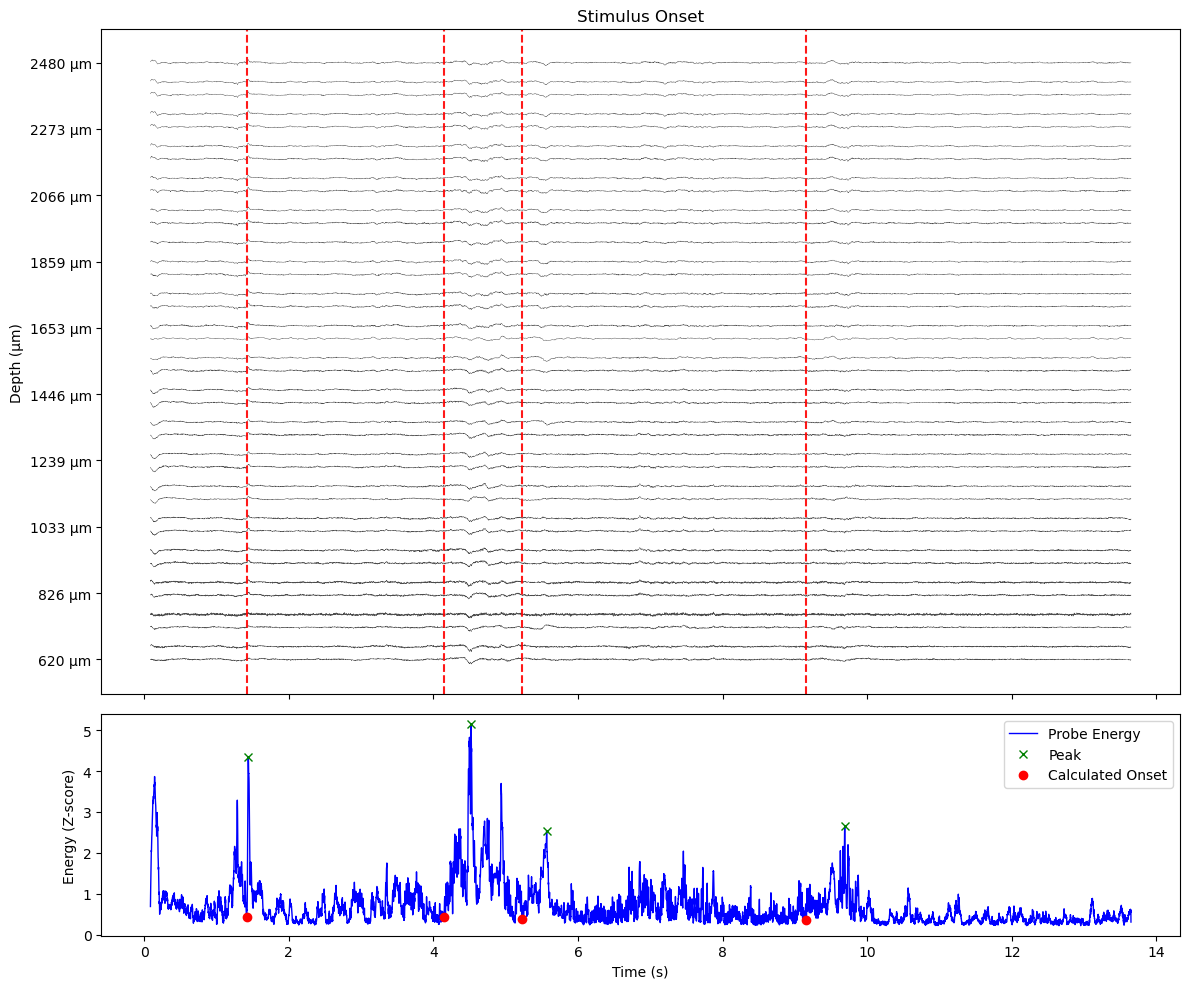


--- Detected Stimulus Times (Seconds) ---
1.4198
4.1490
5.2286
9.1586


In [12]:
# =========================================================
# Stim Onset Detection
# =========================================================
from scipy.signal import find_peaks, peak_widths

# 1. Calculate Global Energy
detection_trace = np.mean(np.abs(Z), axis=1) 

# 2. Find Peaks
peaks, _ = find_peaks(detection_trace, height=2.15, distance=1.0 * fs_lfp)

# 3. Find Onsets using Peak Geometry
widths, width_heights, left_ips, right_ips = peak_widths(detection_trace, peaks, rel_height=0.95)

# Convert to integer indices
onset_indices = np.floor(left_ips).astype(int)
stim_times = t[onset_indices]

# --- FIX 1: Remove the first event from ALL arrays ---
# If we only remove it from stim_times, the bottom plot (peaks/dots) will desync
if len(stim_times) > 0:
    stim_times = stim_times[1:]
    peaks = peaks[1:]
    onset_indices = onset_indices[1:]
    width_heights = width_heights[1:]
    # Also fix the width lines for plotting
    left_ips = left_ips[1:]
    right_ips = right_ips[1:]

print(f"\n--- DETECTED {len(stim_times)} STIMULI ---")

# =========================================================
# PLOT TO VERIFY
# =========================================================
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# --- TOP PLOT: Stacked LFP ---
subset = np.arange(0, Y.shape[1], 5)
for i in subset:
    color = 'black' if in_brain_sel[i] else 'red'
    alpha = 0.7 if in_brain_sel[i] else 0.3
    ax1.plot(t, Y[:, i], color=color, linewidth=0.3, alpha=alpha)

# Add Red Dashed Lines at Onset times
for st in stim_times:
    ax1.axvline(st, color='red', linestyle='--', alpha=0.9, linewidth=1.5)

# --- FIX 2: Correct Depth Labels on Y-Axis ---
# We define ticks based on the 'offsets' used to create Y, mapping them to 'depths_sel'
# offsets are typically monotonic, so we can interpolate.
n_ticks = 10
# Create visual positions for ticks
tick_pos = np.linspace(offsets.min(), offsets.max(), n_ticks)
# Map these visual positions to actual microns
tick_labels_um = np.interp(tick_pos, offsets, depths_sel)

ax1.set_yticks(tick_pos)
# Format as integers
ax1.set_yticklabels([f"{int(d)} µm" for d in tick_labels_um])
ax1.set_ylabel("Depth (µm)")
ax1.set_title(f"Stimulus Onset")

# --- BOTTOM PLOT: Energy Trace ---
ax2.plot(t, detection_trace, color='blue', linewidth=1, label='Probe Energy')
ax2.plot(t[peaks], detection_trace[peaks], 'gx', label='Peak')
ax2.plot(stim_times, detection_trace[onset_indices], 'ro', label='Calculated Onset')

# Visualize the "width" calculation (Corrected to match sliced arrays)
# We reconstruct the x-time for the width lines based on the sliced 'left_ips' and 'right_ips'
# ax2.hlines(width_heights, t[np.floor(left_ips).astype(int)], t[np.floor(right_ips).astype(int)], 
           # color="orange", linestyle=":", label="Width @ 95%")

ax2.set_ylabel("Energy (Z-score)")
ax2.set_xlabel("Time (s)")
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

print("\n--- Detected Stimulus Times (Seconds) ---")
for t_val in stim_times:
    print(f"{t_val:.4f}") 

# --- OPTIONAL: SAVE ONSETS ---
if len(stim_times) > 0:
     np.savetxt(f"results/summaries/{SESSION}_{STIM}_onsets.txt", stim_times)